In [22]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14,6)
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import sklearn.metrics as  metrics
from IPython.display import display
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn import naive_bayes
from sklearn.learning_curve import learning_curve
from sklearn.metrics import  make_scorer
from sklearn.svm import SVC
from mlxtend.feature_selection import plot_sequential_feature_selection as plot_sfs
from sklearn.neural_network import MLPClassifier
sns.set(style="darkgrid")

import os
os.getcwd()

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import  cross_val_score
from sklearn.model_selection import  cross_val_score
from sklearn import cross_validation

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.snowball import EnglishStemmer

from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support

def my_scorer_function(y_test, y_predicted):
    return precision_recall_fscore_support(y_test, y_predicted,pos_label=2)[2][2]
def two_scorer():
    return make_scorer(my_scorer_function, greater_is_better=True)

import unicodedata as uni
import nltk

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB

import sys
nb_stdout = sys.stdout
from vaderSentiment.vaderSentiment import sentiment as vaderSentiment
sys.stdout = nb_stdout

Populating the interactive namespace from numpy and matplotlib


Insert working directory below

In [ ]:
# os.chdir("<insert working directory path here>")

Import dataset

In [23]:
df=pd.read_csv("Tweets.csv")

# Discretize target class
class_dict={"positive":0,"neutral":1,"negative":2}
df.airline_sentiment=df.airline_sentiment.map(class_dict)

Missing values (as % of total dataset)

In [3]:
df.isnull().sum(axis=0)/len(df)*100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.039617
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64

In [7]:
# Transpose class types and map to airlines
pd.crosstab(df.airline,df.airline_sentiment)

# Append trasposition to dataframe
df1=pd.concat([df, pd.get_dummies(df.airline, prefix=None, prefix_sep='_')], axis=1, join='inner')

In [8]:
# Select relevant columns for analysis
df=df1.ix[:,["airline_sentiment","airline_sentiment_confidence","American","Delta","Southwest","US Airways","United","Virgin America","retweet_count","text"]]

# Feature Engineering

Feature Engineering - Dictionary Words

In [9]:
# Load dictionaries for positive and negative words (for sentiments)
pos=pd.read_csv("Positive_Dictionary_Combined.txt",header=None,names=['Positive_Word'],squeeze=False)
neg=pd.read_csv("Negative_Dictionary_Combined.txt",header=None,names=['Negative_Word'],squeeze=False)

# Convert all words in dictionary to lower case
pos["Positive_Word"] = pos["Positive_Word"].apply(lambda x: x.lower())
neg["Negative_Word"] = neg["Negative_Word"].apply(lambda x: x.lower())

# Retain only unique words in dictionaries
pos.drop_duplicates(inplace=True)
neg.drop_duplicates(inplace=True)

In [10]:
# Create features to capture positive and negative word count (based on dictionaries)
df["Positive_Word_Flag"]=df["text"].apply(lambda x: len([i for i in x.split(' ') if i.lower() in list(pos["Positive_Word"])]))
df["Negative_Word_Flag"]=df["text"].apply(lambda x: len([i for i in x.split(' ') if i.lower() in list(neg["Negative_Word"])]))

Feature Engineering - Sarcasm (Mix of common positive words with any negative words)

In [11]:
sarcasm=['great','congrats','thanks','thank']
df["Sarcasm_Dummy"]=df["text"].apply(lambda x: len([i for i in x.split(' ') if i.lower() in sarcasm]))
df["Sarcasm_Flag"]=np.where(((df["Sarcasm_Dummy"]>0) & (df["Negative_Word_Flag"]>0)),1,0)

Feature Engineering - Word Sentiment (VaderSentiment Library)

In [12]:
df["Sentiment"] = df["text"].apply(lambda line: vaderSentiment(line))
df[["Vader_compound","Vader_neg","Vader_neu","Vader_pos"]] = df["Sentiment"].apply(pd.Series)
df["Vader_compound"] = df["Vader_compound"].apply(lambda x: abs(x))
df = df.drop(["Sentiment","Sarcasm_Dummy"],1)

Feature Engineering - Uppercase (Assumed proxy for extreme tone in text. Example: shouting.)

In [13]:
df["Uppercase"] = np.nan
df["Uppercase"] = df["text"].apply(lambda line: [np.sum([1 if re.search('[A-Z]{2,}',word) is not None else 0]) for word in line.split(' ')])
df["Uppercase"] = df["Uppercase"].apply(lambda x: np.sum(x))

Feature Engineering - Special Characters in continuation (Assumed proxy for negativity. Example: !!, ???)

In [14]:
df["Special_Characters"] = np.nan
df["Special_Characters"] = df["text"].apply(lambda line: [np.sum([1 if re.search('[\!\?\.]{2,}',word.replace("https://","").replace("http://","")) is not None else 0]) for word in line.split(' ')])
df["Special_Characters"] = df["Special_Characters"].apply(lambda x: np.sum(x))

Feature Engineering - Emojis

In [13]:
emojis="😀_❤️_😁_😂_😃_😄_😅_😆_😇_😈_😉_😊_😋_😌_😍_😎_😏_😐_😑_😒_😓_😔_😕_😖_😗_😘_😙_😚_😛_😜_😝_😞_😟_😠_😡_😢_😣_😤_😥_😦_😧_😨_😩_😪_😫_😬_😭_😮_😯_😰_😱_😲_😳_😴_😵_😶_😷_😸_😹_😺_😻_😼_😽_😾_😿_🙀_🙁_🙂_🙃_🙄_🙅_🙆_🙇_🙈_🙉_🙊_🙋_🙌_🙍_🙎_🙏_🚀_🚁_🚂_🚃_🚄_🚅_🚆_🚇_🚈_🚉_🚊_🚋_🚌_🚍_🚎_🚏_🚐_🚑_🚒_🚓_🚔_🚕_🚖_🚗_🚘_🚙_🚚_🚛_🚜_🚝_🚞_🚟_🚠_🚡_🚢_🚣_🚤_🚥_🚦_🚧_🚨_🚩_🚪_🚫_🚬_🚭_🚮_🚯_🚰_🚱_🚲_🚳_🚴_🚵_🚶_🚷_🚸_🚹_🚺_🚻_🚼_🚽_🚾_🚿_🛀_🛁_🛂_🛃_🛄_🛅_🛋_🛌_🛍_🛎_🛏_🛐_🛠_🛡_🛢_🛣_🛤_🛥_🛩_🛫_🛬_🛰_🛳_🤐_🤑_🤒_🤓_🤔_🤕_🤖_🤗_🤘_🦀_🦁_🦂_🦃_🦄_🧀"

emojis_list=emojis.split("_")

for i in emojis_list:
    df[i]=0
    
def emoji_f():
    for i in emojis_list:
        for j in range(len(df)):
            text=df.ix[j,'text']
            df.ix[j,i]=str(text).count(str(i))

# code to call emojis
%time emoji_f()

Wall time: 21min 1s


# Train and Test set 

In [15]:
X=df.ix[:,1:]
y=df.ix[:,[0]]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)

# Text Preprocessing
    Includes - 
    -- tokenization
    -- stop words removal
    -- punctuation removal
    -- lower case conversion
    -- removing most frequent and less frequent words
    -- removal of alphanumeric and numeric words
    -- keeping words of length > 1
    -- removal of alphanumeric and numeric strings
    -- n-gram (bigram) generation

In [17]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def lemmatized_words(doc):
#   Lemmatization
   return (wordnet_lemmatizer.lemmatize(w) for w in analyzer(doc) 
           if ((len(re.findall(pattern=r'[0-9]',string=w))==0) and (len(w)>1)))

# N-grams features
v1=CountVectorizer(stop_words ='english',max_df=.5,min_df=2,encoding ="utf-8",lowercase=True, ngram_range=(2,2))

# Lemmatization features
v2=CountVectorizer(stop_words ='english',max_df=.5,min_df=2,encoding ="utf-8",lowercase =True,analyzer=lemmatized_words,token_pattern =r'[a-zA-Z]{3,}')

# Fit the model

In [18]:
v1.fit(X_train.text)
v2.fit(X_train.text)

CountVectorizer(analyzer=<function lemmatized_words at 0x000000000D1E0B38>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding='utf-8', input=u'content', lowercase=True, max_df=0.5,
        max_features=None, min_df=2, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='[a-zA-Z]{3,}', tokenizer=None, vocabulary=None)

In [19]:
X_train_text_TF1=v1.transform(X_train.text)
X_train_text_TF2=v2.transform(X_train.text)
X_test_text_TF1=v1.transform(X_test.text)
X_test_text_TF2=v2.transform(X_test.text)

In [20]:
df_train_newX1=pd.DataFrame(X_train_text_TF1.toarray(), columns=v1.get_feature_names(),index=X_train.index)
df_train_newX2=pd.DataFrame(X_train_text_TF2.toarray(), columns=v2.get_feature_names(),index=X_train.index)

df_train_newX=df_train_newX1
df_train_newX = pd.concat([df_train_newX1, df_train_newX2], axis=1, join='inner')
df_train_newX = df_train_newX1.merge(df_train_newX2, left_index=True,right_index=True)

df_test_newX1=pd.DataFrame(X_test_text_TF1.toarray(), columns=v1.get_feature_names(),index=X_test.index)
df_test_newX2=pd.DataFrame(X_test_text_TF2.toarray(), columns=v2.get_feature_names(),index=X_test.index)

df_test_newX=df_test_newX1
df_test_newX = pd.concat([df_test_newX1, df_test_newX2], axis=1, join='inner')
df_test_newX = df_test_newX1.merge(df_test_newX2, left_index=True,right_index=True)

# Merge Text Features (Word Count, N-Grams) with original dataset

In [21]:
X_train_new = pd.concat([X_train, df_train_newX], axis=1, join='inner')
X_test_new = pd.concat([X_test, df_test_newX], axis=1, join='inner')

# Drop original "text" (tweets) feature
X_train_new=X_train_new.drop("text",axis=1)
X_test_new=X_test_new.drop("text",axis=1)

# Train the model and predict

# Algorithm comparision (10 fold cross validation)

In [32]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

nb = MultinomialNB()
lr = linear_model.LogisticRegression()
etc = ExtraTreesClassifier()
sgd = SGDClassifier()
dt = tree.DecisionTreeClassifier()
bc = BaggingClassifier()
abc = AdaBoostClassifier()

X_cross=X_train_new.append(X_test_new)
y_cross=y_train.append( y_test)
labels= np.asarray(y_cross)
c, r = labels.shape
labels = labels.reshape(c,)
clf_l=[nb,lr,etc,sgd,dt,bc,abc]


In [33]:
X_cross.shape
labels.shape
len(y_cross)
def my_scorer_function(y_test, y_pred_class):
    return precision_recall_fscore_support(y_test,y_pred_class,pos_label=2)[2]
def two_scorer():
    return make_scorer(my_scorer_function, greater_is_better=True)

In [34]:
p=[]
for i in clf_l:
    print i
    clf = cross_val_score(estimator=i,cv=10,n_jobs=1,X=np.array(X_cross),y=labels,scoring=two_scorer())
    clf
    clf.mean()
    p.append(clf.mean())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Dec

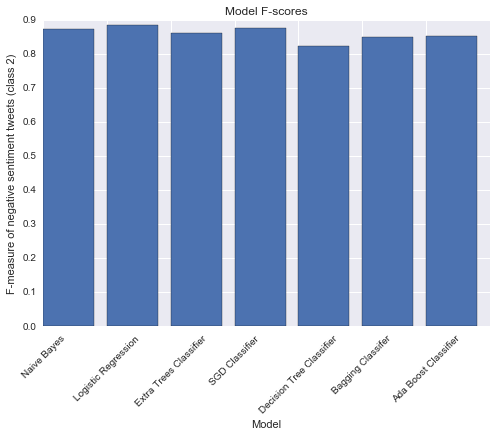

In [38]:
Index = [1,2,3,4,5,6,7]
plt.bar(Index,p)
plt.xticks(Index, ['Naive Bayes','Logistic Regression','Extra Trees Classifier','SGD Classifier','Decision Tree Classifier',
                   'Bagging Classifer','Ada Boost Classifier'],rotation=45)
plt.ylabel('F-measure of negative sentiment tweets (class 2)')
plt.xlabel('Model')
plt.ylim(0,0.9)
plt.title('Model F-scores')

# Model Evaluation 

In [40]:
# calculate accuracy of class predictions
print("The model accuracy is: {}".format(metrics.accuracy_score(y_test, y_pred_class)))

The model accuracy is: 0.817964480874


In [49]:
# Function for confusion matrix
def confusion_matrix_func(y_test,y_predicted):
    
    confusionMatrix=confusion_matrix(y_test,y_predicted)
    Confu_matrix_df=pd.DataFrame(confusionMatrix)
    Confu_matrix_df.columns.name='PREDICTED'
    Confu_matrix_df.index.name='ACTUAL'
    Confu_matrix_df.name='CONFUSION MATRIX'
    
    print "CONFUSION MATRIX"
    print display(Confu_matrix_df)
    
    confusionmatrix=Confu_matrix_df
    print "Accuracy of model is {:.10f}".format(metrics.accuracy_score(y_test,y_predicted))
    
    precision=(100*float(confusionmatrix.ix[2,2])/(confusionmatrix.ix[2,2]+confusionmatrix.ix[0,2]+confusionmatrix.ix[1,2]))
    recall=(100*float(confusionmatrix.ix[2,2])/(confusionmatrix.ix[2,2]+confusionmatrix.ix[2,0]+confusionmatrix.ix[2,1]))
    
    print "Precision of Positive class('negative sentiment') is {:.10f}".format(precision)
    print "Recall of Positive class('negative sentiment') is {:.10f}".format(recall)
    
    f_measure=((2)*precision*recall)/((recall)+(precision))
    print "The F-measure of the Positive class is {:.10f}".format(f_measure)
    return Confu_matrix_df

# Calculate evaluation metrics with confusion matrix function
df_confusion=confusion_matrix_func(y_test,y_pred_class)
precision_recall_fscore_support(y_test,y_pred_class,pos_label=2)[2]

# Concat predicted and actual sentiment classes for comparison
df_analyze_prediction=pd.concat([X_test.text, y_test,pd.DataFrame(y_pred_class,index=X_test.index)], axis=1, join='inner')
df_analyze_prediction.columns=["text","actual_sentiment","predicted_sentiment"]

df_analyze_prediction.predicted_sentiment.value_counts()

CONFUSION MATRIX


PREDICTED,0,1,2
ACTUAL,,,
0,334,54,71
1,65,347,168
2,41,134,1714


None
Accuracy of model is 0.8179644809
Precision of Positive class('negative sentiment') is 87.7624167947
Recall of Positive class('negative sentiment') is 90.7358390683
The F-measure of the Positive class is 89.2243623113


2    1953
1     535
0     440
Name: predicted_sentiment, dtype: int64

# Negative Tweets classified as Positive 

In [42]:
x=df_analyze_prediction.ix[((df_analyze_prediction.actual_sentiment==2) & (df_analyze_prediction.predicted_sentiment==0)),"text"]

print("Total number of negative tweets classified as positive: {}\n".format(len(x)))

print("Tweets:\n")
for i in x:
    print i

Total number of negative tweets classified as positive: 41

Tweets:

@united thanks for having ground crews that are surprised when flights arrive. #beingsuckontarmacsucks!
@USAirways yes, thanks but took forever
@united thanks for the reply. To clarify, the airfare is similar to your likely intended peer group. The $3 beer charge, however, is not
@USAirways suggest you failures make a HUGE donation to @the_USO  Charlotte, NC as THEY provided GREAT customer service today, unlike you.
&lt;3 &lt;3 RT @SouthwestAir! @danihampton Sorry to hear about the WiFi connection, Dani. Please DM us your conf # so we can help you. Thanks!
@USAirways Been dealing w/ @americanair to solve the probs your team created. Your Manch, NH staff is clearly your C-team, btw. #NotEvenJV
@USAirways great job today In ruining 45 people's vacation. Thanks to your incompetent pilot and staff we have all now missed our flights
@united Well, to the degree that he could... Just to know, after this experience I'm Cancel

# Negative Tweets classified as Neutral 

In [43]:
x=df_analyze_prediction.ix[((df_analyze_prediction.actual_sentiment==2) & (df_analyze_prediction.predicted_sentiment==1)),"text"]

print("Total number of negative tweets classified as neutral: {}\n".format(len(x)))

print("Tweets:\n")
for i in x:
    print i

Total number of negative tweets classified as neutral: 134

Tweets:

@JetBlue I can probably find some of them. Are the ticket #s on there?
@USAirways : When You've Got to Get There, We've Got Excuses! #usairwaysfail
@JetBlue bag is supposedly here in Boston
@united the lounge tells us they have no pillows for my grandma as one of the ladies opens the closet and I see 2 right there. #unitedlies
Includes @KCIAirport “@SouthwestAir: Inclement weather may impact scheduled service in. ReFlight Booking Problems options available: http://t.co/KeyrpFlHil”
@AmericanAir on Feb. 15th your rep gave me the record locator and told me I'd be receiving an email with the itinerary and confirmation.
@united Bummer. Might have to go with @AmericanAir card instead. TY for response though.
@JetBlue it seems I never received an ID, just a password.
@united plus what about food? And taxis?
@SouthwestAir everyones flights who were Cancelled Flightled today DESERVE 1
@VirginAmerica
wjere is our luggage #so sl

# WordCloud

In [55]:
from wordcloud import WordCloud,STOPWORDS
x=df[df['airline_sentiment']==2]
words=(' '.join(list(x['text'].values)))

(-0.5, 2999.5, 2499.5, -0.5)

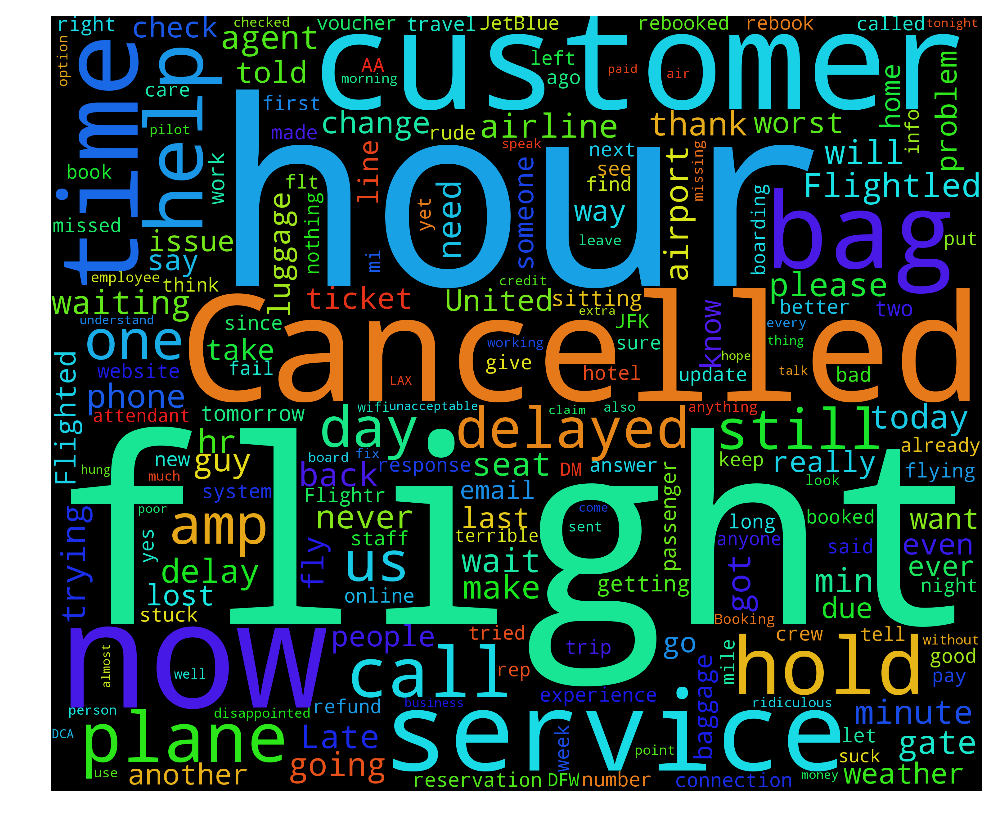

In [56]:
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()